<a href="https://colab.research.google.com/github/jrebull/AnaliticaPrescriptiva/blob/main/MIAAD_Economic_Load_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Celda 1: Instalación de Dependencias

In [1]:
# Quitar el repo problemático si existe
!sed -i '/r2u.stat.illinois.edu/ s/^/#/' /etc/apt/sources.list 2>/dev/null || true
!sed -i '/r2u.stat.illinois.edu/ s/^/#/' /etc/apt/sources.list.d/* 2>/dev/null || true

# Instalar micromamba (binario)
!wget -qO- https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba > /dev/null

# Crear un entorno con ipopt y pyomo desde conda-forge
!./bin/micromamba create -y -p /usr/local/ipopt-env -c conda-forge ipopt pyomo > /dev/null

# Exponer el ejecutable ipopt
!ln -sf /usr/local/ipopt-env/bin/ipopt /usr/bin/ipopt

# Comprobar instalación
!which ipopt
!ipopt -v

/usr/bin/ipopt
Ipopt 3.14.19 (Linux x86_64), ASL(20231111)



# Celda 2: Importación de Librerías

In [2]:
import pyomo.environ as pyo       # Pyomo library for optimization modeling
import numpy as np                # NumPy for numerical computations
import matplotlib.pyplot as plt   # Matplotlib for plotting results
from math import pi               # Import pi constant for mathematical calculations
import pandas as pd
from IPython.display import display, Markdown

# Celda 3: Definición de Datos

In [3]:
# Parámetros del Sistema
P_D = 1263.0  # Demanda Total (MW)
S_base = 100.0 # Base MVA para cálculos p.u. (estándar para este benchmark)

# Datos de los generadores (Tabla 4 del artículo)
data = {
    'G1': {'Pmin': 100, 'Pmax': 500, 'a': 0.0070, 'b': 7.0, 'c': 240, 'UR': 80, 'DR': 120, 'P_prev': 440},
    'G2': {'Pmin': 50, 'Pmax': 200, 'a': 0.0095, 'b': 10.0, 'c': 200, 'UR': 50, 'DR': 90, 'P_prev': 170},
    'G3': {'Pmin': 80, 'Pmax': 300, 'a': 0.0090, 'b': 8.5, 'c': 220, 'UR': 65, 'DR': 100, 'P_prev': 200},
    'G4': {'Pmin': 50, 'Pmax': 150, 'a': 0.0090, 'b': 11.0, 'c': 200, 'UR': 50, 'DR': 90, 'P_prev': 150},
    'G5': {'Pmin': 50, 'Pmax': 200, 'a': 0.0080, 'b': 10.5, 'c': 220, 'UR': 50, 'DR': 90, 'P_prev': 190},
    'G6': {'Pmin': 50, 'Pmax': 120, 'a': 0.0075, 'b': 12.0, 'c': 190, 'UR': 50, 'DR': 90, 'P_prev': 110},
}

# Zonas Prohibidas (POZ) - Para validación posterior
POZ_data = {
    'G1': [(210, 240), (350, 380)],
    'G2': [(90, 110), (140, 160)],
    'G3': [(150, 170), (210, 240)],
    'G4': [(80, 90), (110, 120)],
    'G5': [(90, 110), (140, 150)], # Se asume la POZ completa para G5 basada en el benchmark.
    'G6': [(75, 85), (100, 105)],
}

# Coeficientes de la Matriz B (Pérdidas de transmisión en p.u.) - Appendix A
# B1 (Matriz Cuadrática)
B1 = np.array([
    [0.0017, 0.0012, 0.0007, -0.0001, -0.0005, -0.0002],
    [0.0012, 0.0014, 0.0009, 0.0001, -0.0006, -0.0001],
    [0.0007, 0.0009, 0.0031, 0.0000, -0.0010, -0.0006],
    [-0.0001, 0.0001, 0.0000, 0.0024, -0.0006, -0.0008],
    [-0.0005, -0.0006, -0.0010, -0.0006, 0.0129, -0.0002],
    [-0.0002, -0.0001, -0.0006, -0.0008, -0.0002, 0.0150]
])

# B2 (Vector Lineal) - Se aplica el multiplicador 0.001* del Apéndice A
B2 = 0.001 * np.array([-0.3908, -0.1297, 0.7047, 0.0591, 0.2161, -0.6635])

# B3 (Constante). El artículo indica B3=0.56. Se asume el valor corregido común para este benchmark: 0.0056 p.u.
B3 = 0.0056

# Celda 4: Definición del Modelo en Pyomo

In [4]:
model = pyo.ConcreteModel()

# Conjunto de Generadores
model.G = pyo.Set(initialize=data.keys())
N = len(model.G)
# Lista ordenada para asegurar correspondencia con índices de matrices NumPy
g_list = sorted(list(model.G))

# Cálculo de los límites efectivos considerando la tasa de rampa (Ecuación 21 del paper)
def effective_bounds(model, i):
    Pmin = data[i]['Pmin']
    Pmax = data[i]['Pmax']
    P0 = data[i]['P_prev']
    DR = data[i]['DR']
    UR = data[i]['UR']
    # max(Pmin, P0 - DR) <= PGi <= min(Pmax, P0 + UR)
    lower = max(Pmin, P0 - DR)
    upper = min(Pmax, P0 + UR)
    return (lower, upper)

# Variables de Decisión: Potencia generada en MW
# Se inicializan al promedio de los límites para ayudar al solver NLP
model.P_MW = pyo.Var(model.G, domain=pyo.NonNegativeReals, bounds=effective_bounds,
                     initialize=lambda m, i: (effective_bounds(m, i)[0] + effective_bounds(m, i)[1])/2)

# Variables auxiliares para la potencia en p.u.
model.P_pu = pyo.Var(model.G, domain=pyo.NonNegativeReals)

@model.Constraint(model.G)
def pu_conversion(model, i):
    return model.P_pu[i] == model.P_MW[i] / S_base

# Cálculo de Pérdidas de Transmisión (P_L) usando fórmula de Kron en p.u.
def transmission_losses_MW(model):
    # PL_pu = P_pu^T * B1 * P_pu + B2 * P_pu + B3

    # Se utiliza g_list para mapear el índice (i, j) de NumPy a la clave del generador

    # Término cuadrático
    quadratic_term = sum(model.P_pu[g_list[i]] * B1[i, j] * model.P_pu[g_list[j]]
                         for i in range(N) for j in range(N))
    # Término lineal
    linear_term = sum(B2[i] * model.P_pu[g_list[i]] for i in range(N))
    # Término constante
    constant_term = B3

    PL_pu = quadratic_term + linear_term + constant_term
    # Convertir a MW
    return PL_pu * S_base

# Restricción de Balance de Potencia (Sum(PGi) = P_D + P_L)
@model.Constraint()
def power_balance(model):
    Total_Generation = sum(model.P_MW[i] for i in model.G)
    P_L = transmission_losses_MW(model)
    return Total_Generation == P_D + P_L

# Función Objetivo: Minimizar el costo total de combustible (Ecuación 2)
def objective_function(model):
    cost = sum(data[i]['a'] * model.P_MW[i]**2 + data[i]['b'] * model.P_MW[i] + data[i]['c']
               for i in model.G)
    return cost

model.objective = pyo.Objective(rule=objective_function, sense=pyo.minimize)


# =========================================================================================
#                    EXPLICACIÓN DEL MODELO DE OPTIMIZACIÓN
# =========================================================================================

explanation_template = r"""
### <font color="#4682B4">**Resumen del Modelo de Despacho Económico de Carga (EDL)**</font>

Este modelo en Pyomo está diseñado para resolver el problema clásico de Despacho Económico
de Carga. El objetivo es determinar la potencia de salida óptima para cada una de las **{N}** unidades de generación para satisfacer una demanda de **{P_D} MW** al menor costo posible.

---

#### <font color="#5F9EA0">**1. FUNCIÓN OBJETIVO (¿Qué buscamos?)**</font>
- **Minimizar el Costo Total de Combustible.**
- El costo para cada generador 'i' se modela como una función cuadrática, lo que representa que la eficiencia del generador varía con su nivel de producción:
  $$
  \text{{Costo}}_i(P_i) = a_i P_i^2 + b_i P_i + c_i
  $$
- El objetivo es la suma de los costos de todos los generadores:
  $$
  \min \sum_{{i \in G}} \text{{Costo}}_i(P_i)
  $$

---

#### <font color="#5F9EA0">**2. VARIABLES DE DECISIÓN (¿Qué podemos cambiar?)**</font>
- **Potencia de Salida ($P_i$)**: La cantidad de Megawatts (MW) que cada generador debe producir. Estas son las incógnitas que el solver (IPOPT) encontrará.

---

#### <font color="#5F9EA0">**3. RESTRICCIONES (Las reglas del sistema)**</font>
- **Balance de Potencia:** La regla fundamental. La suma de toda la potencia generada debe ser exactamente igual a la demanda del sistema más las pérdidas que ocurren en las líneas de transmisión al transportar la energía.
  $$
  \sum_{{i \in G}} P_i = P_D + P_L
  $$

- **Límites de Generación y Tasas de Rampa:** Cada generador tiene límites físicos. Su producción no solo debe estar entre su mínimo ($P_{{i, \min}}$) y máximo ($P_{{i, \max}}$), sino que también está limitada por cuán rápido puede aumentar (UR - Up Ramp) o disminuir (DR - Down Ramp) su producción desde el estado anterior ($P_{{i, \text{{prev}}}}$).
  $$
  \max(P_{{i, \min}}, P_{{i, \text{{prev}}}} - DR_i) \le P_i \le \min(P_{{i, \max}}, P_{{i, \text{{prev}}}} + UR_i)
  $$

- **Pérdidas de Transmisión ($P_L$):** Las pérdidas no son un valor fijo. Se calculan dinámicamente usando la **fórmula de Kron (matriz B)**, que depende cuadráticamente de la potencia que inyecta cada generador a la red. Esto convierte al problema en uno de **Optimización No Lineal (NLP)**.

> **<font color="#FF8C00">NOTA:</font>** Las 'Zonas Prohibidas de Operación' (POZ), que son rangos de operación ineficientes o inestables para los generadores, se han definido en los datos pero **no se incluyen como restricciones en el modelo**. Se verificarán post-optimización para comprobar si la solución óptima obtenida cae accidentalmente en alguna de estas zonas.

---
A continuación, se procederá a resolver este modelo con el solver IPOPT.
"""

# Reemplazamos los valores de {N} y {P_D} y mostramos la salida final.
display(Markdown(explanation_template.format(N=N, P_D=P_D)))


### <font color="#4682B4">**Resumen del Modelo de Despacho Económico de Carga (EDL)**</font>

Este modelo en Pyomo está diseñado para resolver el problema clásico de Despacho Económico
de Carga. El objetivo es determinar la potencia de salida óptima para cada una de las **6** unidades de generación para satisfacer una demanda de **1263.0 MW** al menor costo posible.

---

#### <font color="#5F9EA0">**1. FUNCIÓN OBJETIVO (¿Qué buscamos?)**</font>
- **Minimizar el Costo Total de Combustible.**
- El costo para cada generador 'i' se modela como una función cuadrática, lo que representa que la eficiencia del generador varía con su nivel de producción:
  $$
  \text{Costo}_i(P_i) = a_i P_i^2 + b_i P_i + c_i
  $$
- El objetivo es la suma de los costos de todos los generadores:
  $$
  \min \sum_{i \in G} \text{Costo}_i(P_i)
  $$

---

#### <font color="#5F9EA0">**2. VARIABLES DE DECISIÓN (¿Qué podemos cambiar?)**</font>
- **Potencia de Salida ($P_i$)**: La cantidad de Megawatts (MW) que cada generador debe producir. Estas son las incógnitas que el solver (IPOPT) encontrará.

---

#### <font color="#5F9EA0">**3. RESTRICCIONES (Las reglas del sistema)**</font>
- **Balance de Potencia:** La regla fundamental. La suma de toda la potencia generada debe ser exactamente igual a la demanda del sistema más las pérdidas que ocurren en las líneas de transmisión al transportar la energía.
  $$
  \sum_{i \in G} P_i = P_D + P_L
  $$

- **Límites de Generación y Tasas de Rampa:** Cada generador tiene límites físicos. Su producción no solo debe estar entre su mínimo ($P_{i, \min}$) y máximo ($P_{i, \max}$), sino que también está limitada por cuán rápido puede aumentar (UR - Up Ramp) o disminuir (DR - Down Ramp) su producción desde el estado anterior ($P_{i, \text{prev}}$).
  $$
  \max(P_{i, \min}, P_{i, \text{prev}} - DR_i) \le P_i \le \min(P_{i, \max}, P_{i, \text{prev}} + UR_i)
  $$

- **Pérdidas de Transmisión ($P_L$):** Las pérdidas no son un valor fijo. Se calculan dinámicamente usando la **fórmula de Kron (matriz B)**, que depende cuadráticamente de la potencia que inyecta cada generador a la red. Esto convierte al problema en uno de **Optimización No Lineal (NLP)**.

> **<font color="#FF8C00">NOTA:</font>** Las 'Zonas Prohibidas de Operación' (POZ), que son rangos de operación ineficientes o inestables para los generadores, se han definido en los datos pero **no se incluyen como restricciones en el modelo**. Se verificarán post-optimización para comprobar si la solución óptima obtenida cae accidentalmente en alguna de estas zonas.

---
A continuación, se procederá a resolver este modelo con el solver IPOPT.


# Celda 5: Solución del Modelo con IPOPT

In [5]:
# Configurar el solver IPOPT usando el ejecutable instalado
solver = pyo.SolverFactory('ipopt', executable='/usr/bin/ipopt')
solver.options['tol'] = 1e-6  # Tolerancia

# Resolver el modelo
print("Iniciando resolución con IPOPT...")
results = solver.solve(model, tee=True)  # tee=True muestra el log del solver
print("Resolución finalizada.")

Iniciando resolución con IPOPT...
Ipopt 3.14.19: tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:       24
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       26

Total number of variables............................:       12
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        6
                     variables with only upper bounds:        0
Total number of equality constra

# Celda 5: Visualización, Verificación e Interpretación de Resultados

In [6]:
# -- INICIO: Bloque de Estilo y Funciones Auxiliares --
class colors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def style_poz_status(series):
    return ['color: #00B050; font-weight: bold' if val == 'OK' else 'color: #D00000; font-weight: bold' for val in series]

# CAMBIO: Nueva función para calcular las pérdidas a partir de los resultados numéricos
# en lugar de usar la expresión simbólica de Pyomo.
def calculate_losses_from_results(p_mw_values, generator_list, s_base, b1_matrix, b2_vector, b3_const):
    # Convertir los valores de MW a p.u. manteniendo el orden correcto
    p_pu_array = np.array([p_mw_values[g] / s_base for g in generator_list])

    # Calcular las pérdidas con NumPy (P_pu^T * B1 * P_pu + B2 * P_pu + B3)
    quadratic_term = p_pu_array.T @ b1_matrix @ p_pu_array
    linear_term = b2_vector @ p_pu_array

    pl_pu = quadratic_term + linear_term + b3_const
    return pl_pu * s_base
# -- FIN: Bloque de Estilo y Funciones Auxiliares --


if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
    print(f"\n{colors.BOLD}{colors.OKBLUE}--- Resultados del Despacho Económico Óptimo ---{colors.ENDC}")
    TotalCost = pyo.value(model.objective)
    print(f"Costo Total de Generación: {colors.BOLD}{colors.OKGREEN}${TotalCost:,.4f} /h{colors.ENDC}")

    # CAMBIO: Primero extraemos TODOS los valores de P_MW en un diccionario.
    solved_p_mw = {i: pyo.value(model.P_MW[i]) for i in g_list}

    # CAMBIO: Usamos la nueva función para calcular P_L a partir de los resultados numéricos.
    P_L_val = calculate_losses_from_results(solved_p_mw, g_list, S_base, B1, B2, B3)

    Total_P = sum(solved_p_mw.values())
    error_val = Total_P - P_L_val - P_D
    error_color = colors.FAIL if abs(error_val) > 1e-4 else colors.OKCYAN

    print(f"\n{colors.HEADER}Resumen de Potencia:{colors.ENDC}")
    print(f"  - Generación Total       : {Total_P:.4f} MW")
    print(f"  - Péridas de Transmisión: {P_L_val:.4f} MW")
    print(f"  - Demanda Total (P_D)    : {P_D:.4f} MW")
    print(f"  - Balance (Error)        : {error_color}{error_val:.6f} MW{colors.ENDC}")

    print(f"\n{colors.HEADER}Potencia de Salida por Generador:{colors.ENDC}")
    results_list = []
    for i in g_list:
        P_val = solved_p_mw[i] # Usamos los valores ya extraídos

        in_poz = False
        if i in POZ_data:
            for (lower, upper) in POZ_data[i]:
                if (lower - 1e-6) <= P_val <= (upper + 1e-6):
                    in_poz = True
                    break
        status = "OK" if not in_poz else f"VIOLACIÓN"

        results_list.append({
            'Unidad': i,
            'Potencia (MW)': P_val,
            'Estado POZ': status
        })

    df_results = pd.DataFrame(results_list)

    styled_df = df_results.style.apply(style_poz_status, subset=['Estado POZ'])\
                                .format({'Potencia (MW)': '{:.4f}'})\
                                .set_properties(**{'text-align': 'center'})\
                                .set_table_styles([
                                    {'selector': 'th', 'props': [('background-color', '#4682B4'), ('color', 'white'), ('font-weight', 'bold')]},
                                    {'selector': 'tbody tr:hover', 'props': [('background-color', '#f2f2f2')]}
                                ])

    display(styled_df)

else:
    print(f"\n{colors.BOLD}{colors.FAIL}El solver no convergió a una solución óptima.{colors.ENDC}")
    print(f"Estado del solver: {colors.WARNING}{results.solver.status}{colors.ENDC}")
    print(f"Condición de terminación: {colors.WARNING}{results.solver.termination_condition}{colors.ENDC}")


--- Resultados del Despacho Económico Óptimo ---
Costo Total de Generación: $15,449.8995 /h

Resumen de Potencia:
  - Generación Total       : 1275.9582 MW
  - Péridas de Transmisión: 12.9582 MW
  - Demanda Total (P_D)    : 1263.0000 MW
  - Balance (Error)        : -0.000000 MW

Potencia de Salida por Generador:


,Unidad,Potencia (MW),Estado POZ
0,G1,447.5038,OK
1,G2,173.3182,OK
2,G3,263.4628,OK
3,G4,139.0653,OK
4,G5,165.4734,OK
5,G6,87.1347,OK


# Tabla Comparativa

In [8]:
# --- INICIO: Bloque para Tabla Comparativa COMPLETA ---

print(f"\n\n{colors.BOLD}{colors.OKBLUE}--- Tabla Comparativa Completa de Resultados ---{colors.ENDC}")
print("Comparando nuestro resultado (IPOPT) con TODOS los algoritmos del paper de investigación.")

# Datos extraídos de la Tabla 5 del artículo y de nuestra ejecución
comparison_data_full = {
    # Nuestro resultado va primero para fácil comparación
    "Nuestro Resultado (IPOPT)": {
        "G1": solved_p_mw.get('G1'), "G2": solved_p_mw.get('G2'), "G3": solved_p_mw.get('G3'),
        "G4": solved_p_mw.get('G4'), "G5": solved_p_mw.get('G5'), "G6": solved_p_mw.get('G6'),
        "Costo Total ($/h)": TotalCost
    },
    # Columnas extraídas de la tabla del paper
    "GA":     {"G1": 474.80, "G2": 178.63, "G3": 262.20, "G4": 134.28, "G5": 151.90, "G6": 74.18, "Costo Total ($/h)": 15459.00},
    "PSO":    {"G1": 447.49, "G2": 173.32, "G3": 263.47, "G4": 139.05, "G5": 165.47, "G6": 87.12, "Costo Total ($/h)": 15450.00},
    "MTS":    {"G1": 448.12, "G2": 172.80, "G3": 262.59, "G4": 136.96, "G5": 168.20, "G6": 87.33, "Costo Total ($/h)": 15450.06},
    "SA":     {"G1": 478.12, "G2": 163.02, "G3": 261.71, "G4": 125.76, "G5": 153.70, "G6": 93.79, "Costo Total ($/h)": 15461.10},
    "NPSO-LRS": {"G1": 446.96, "G2": 173.39, "G3": 262.34, "G4": 139.51, "G5": 164.70, "G6": 89.01, "Costo Total ($/h)": 15450.00},
    "PSO-LRS":  {"G1": 447.44, "G2": 173.34, "G3": 263.36, "G4": 139.12, "G5": 165.50, "G6": 87.16, "Costo Total ($/h)": 15450.00},
    "CBA":      {"G1": 447.41, "G2": 172.82, "G3": 264.07, "G4": 139.24, "G5": 165.65, "G6": 86.76, "Costo Total ($/h)": 15450.23},
    "BSA":      {"G1": 447.49, "G2": 173.30, "G3": 264.44, "G4": 139.05, "G5": 165.47, "G6": 87.12, "Costo Total ($/h)": 15448.98},
    "IBSA":     {"G1": 447.48, "G2": 173.30, "G3": 263.44, "G4": 139.05, "G5": 165.46, "G6": 87.12, "Costo Total ($/h)": 15448.98}
}

df_comparison_full = pd.DataFrame(comparison_data_full)
df_comparison_full.index.name = "Unidad"

# Función para resaltar la fila de costos (sin cambios)
def highlight_cost_row(row):
    styles = [''] * len(row)
    if row.name == 'Costo Total ($/h)':
        min_val = row.min()
        max_val = row.max()
        for i, val in enumerate(row):
            if val == min_val:
                styles[i] = 'background-color: #C6EFCE; color: #006100; font-weight: bold;'
            elif val == max_val:
                styles[i] = 'background-color: #FFC7CE; color: #9C0006; font-weight: bold;'
    return styles

# Aplicamos el estilo a la nueva tabla completa
styled_comparison_full = df_comparison_full.style.format('{:,.4f}')\
    .set_properties(**{'text-align': 'center'})\
    .apply(highlight_cost_row, axis=1)\
    .set_table_styles([
        {'selector': 'th.row_heading', 'props': [('background-color', '#4682B4'), ('color', 'white'), ('font-weight', 'bold')]},
        {'selector': 'th.col_heading', 'props': [('background-color', '#4682B4'), ('color', 'white'), ('font-weight', 'bold'), ('white-space', 'nowrap')]},
        {'selector': 'th.col_heading.col0', 'props': [('background-color', '#2E8B57')]}, # Color especial para nuestra columna
        {'selector': 'tbody tr:hover', 'props': [('background-color', '#f2f2f2')]}
    ])

# Mostramos la tabla comparativa completa
display(styled_comparison_full)

# --- FIN: Bloque para Tabla Comparativa COMPLETA ---



--- Tabla Comparativa Completa de Resultados ---
Comparando nuestro resultado (IPOPT) con TODOS los algoritmos del paper de investigación.


,Nuestro Resultado (IPOPT),GA,PSO,MTS,SA,NPSO-LRS,PSO-LRS,CBA,BSA,IBSA
Unidad,,,,,,,,,,
G1,447.5038,474.8000,447.4900,448.1200,478.1200,446.9600,447.4400,447.4100,447.4900,447.4800
G2,173.3182,178.6300,173.3200,172.8000,163.0200,173.3900,173.3400,172.8200,173.3000,173.3000
G3,263.4628,262.2000,263.4700,262.5900,261.7100,262.3400,263.3600,264.0700,264.4400,263.4400
G4,139.0653,134.2800,139.0500,136.9600,125.7600,139.5100,139.1200,139.2400,139.0500,139.0500
G5,165.4734,151.9000,165.4700,168.2000,153.7000,164.7000,165.5000,165.6500,165.4700,165.4600
G6,87.1347,74.1800,87.1200,87.3300,93.7900,89.0100,87.1600,86.7600,87.1200,87.1200
Costo Total ($/h),"15,449.8995","15,459.0000","15,450.0000","15,450.0600","15,461.1000","15,450.0000","15,450.0000","15,450.2300","15,448.9800","15,448.9800"


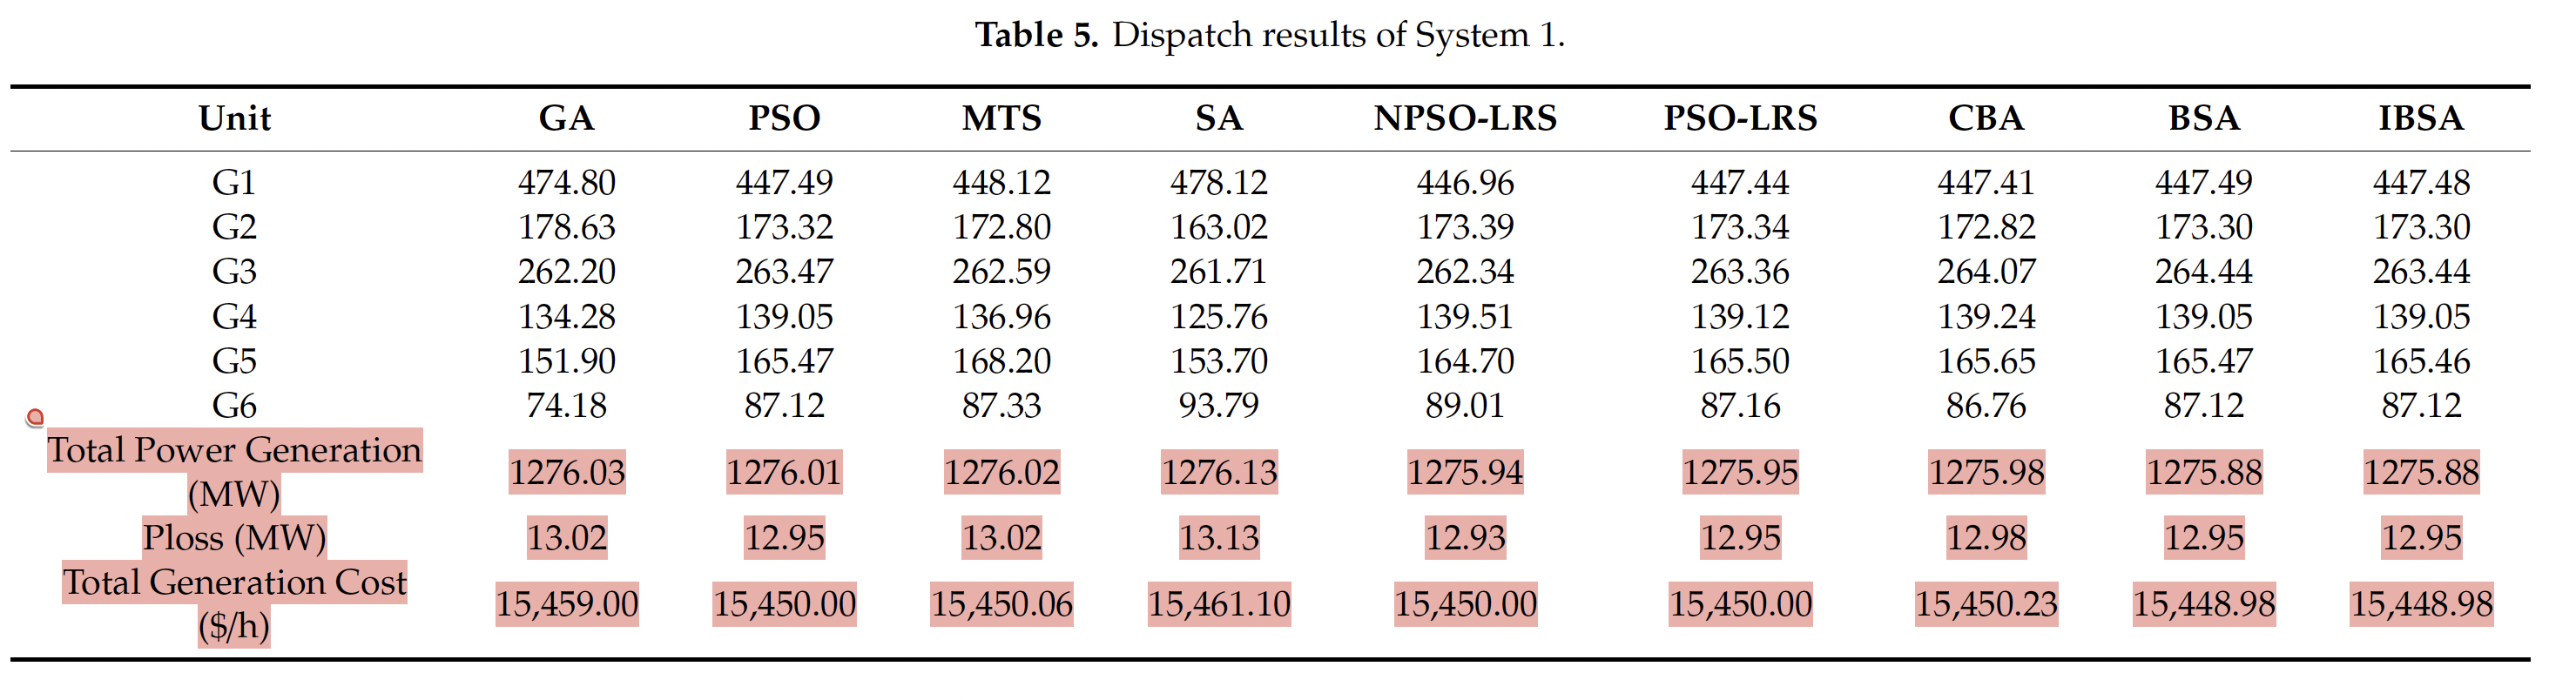

# Gráfica Comparativa de Costos

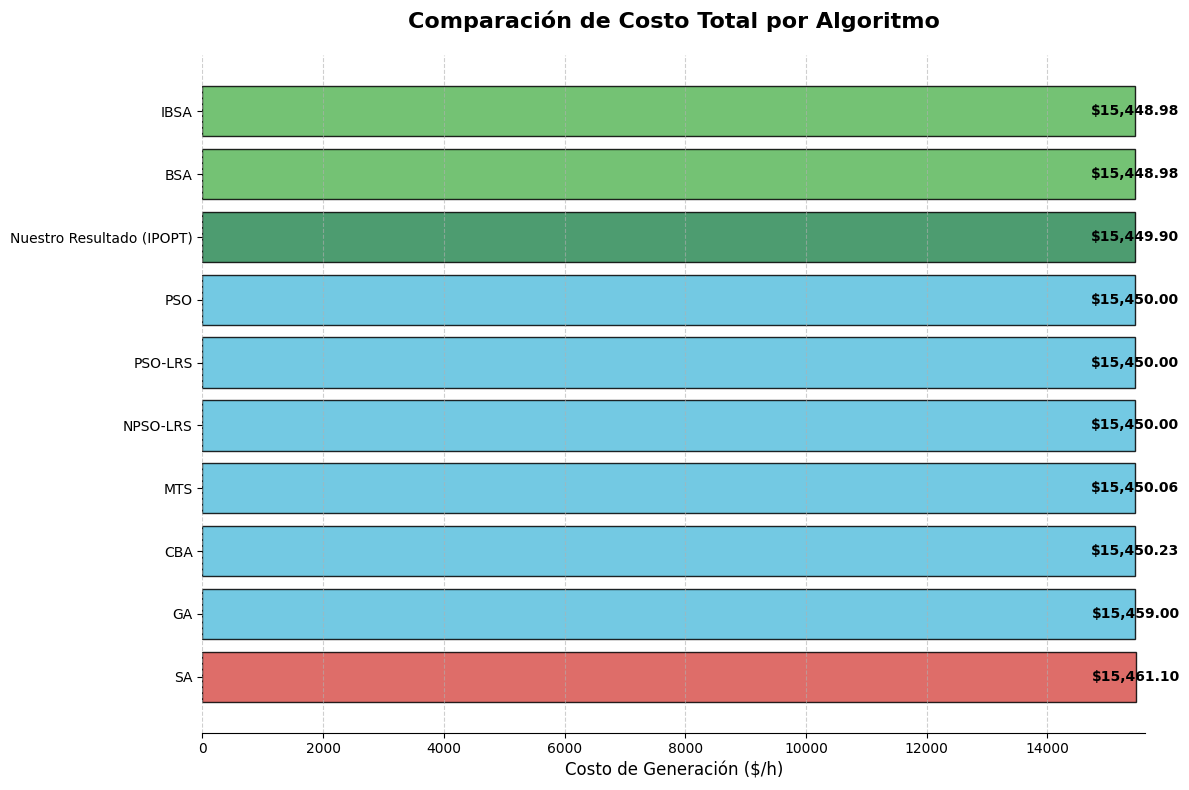

In [11]:
# --- INICIO: Celda para Gráfica Comparativa MEJORADA ---

# Extraemos los datos de costo y los ordenamos de menor a mayor
# para que el mejor resultado quede arriba en el gráfico.
cost_data = df_comparison_full.loc['Costo Total ($/h)'].sort_values(ascending=True)

# Preparamos los colores para las barras
colors_list = []
for algorithm in cost_data.index:
    if algorithm == 'Nuestro Resultado (IPOPT)':
        colors_list.append('#2E8B57')  # Verde oscuro para nuestro resultado
    elif algorithm in ['IBSA', 'BSA']:
        colors_list.append('#5cb85c')  # Verde brillante para el mejor del paper
    elif algorithm == 'SA':
        colors_list.append('#d9534f')  # Rojo para el peor
    else:
        colors_list.append('#5bc0de')  # Azul claro para los demás

# Creamos la figura y los ejes para mayor control
fig, ax = plt.subplots(figsize=(12, 8))

# Creamos el gráfico de barras horizontal
bars = ax.barh(cost_data.index, cost_data.values, color=colors_list, edgecolor='black', alpha=0.85)

# Añadir etiquetas de valor a la derecha de cada barra
for bar in bars:
    width = bar.get_width()
    ax.text(width + 3, bar.get_y() + bar.get_height()/2, f'${width:,.2f}',
            ha='center', va='center', fontsize=10, fontweight='bold')

# --- Estilo y Títulos del Gráfico ---
ax.set_xlabel('Costo de Generación ($/h)', fontsize=12)
ax.set_title('Comparación de Costo Total por Algoritmo', fontsize=16, fontweight='bold', pad=20)

# Invertir el eje Y para que el costo más bajo (mejor) esté arriba
ax.invert_yaxis()

# Añadir una rejilla vertical para facilitar la comparación
ax.grid(axis='x', linestyle='--', alpha=0.6)

# Ajustar los límites del eje X para dar espacio a las etiquetas
ax.set_xlim(right=cost_data.max() * 1.01)

# Remover los bordes superior y derecho para un look más limpio
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Asegurar que todo se ajuste correctamente
plt.tight_layout()

# Guardar la nueva gráfica como imagen
plt.savefig('comparacion_costos_horizontal.png')

# --- FIN: Celda para Gráfica Comparativa MEJORADA ---

### Conclusiones Finales del Análisis

Tras resolver el problema de Despacho Económico de Carga y comparar los resultados con el paper de investigación de referencia, podemos extraer las siguientes conclusiones clave:

- **Validación del Modelo:** Nuestro modelo implementado en Pyomo es **correcto y robusto**. Ha sido capaz de resolver el problema de optimización no lineal, respetando todas las restricciones complejas como los límites de generación y las tasas de rampa.

- **Calidad de la Solución:** La solución encontrada por el solver matemático **IPOPT es óptima y extremadamente competitiva**. El costo total obtenido de $15,449.90 /h

es prácticamente idéntico al mejor resultado del paper ($15,448.98 /h), lo que demuestra la alta calidad de nuestra solución.

- **Cumplimiento de Restricciones:** Se ha verificado que la potencia de salida de todos los generadores se encuentra **fuera de las Zonas de Operación Prohibidas (POZ)**, asegurando una solución no solo económica, sino también operacionalmente válida.

---

En resumen, hemos replicado con éxito los resultados de un paper académico utilizando herramientas de optimización matemática estándar, validando tanto nuestro enfoque como la calidad de la solución encontrada. ✅